In [1]:
import numpy as np

import matplotlib.pyplot as plt

from pulser import Pulse, Sequence, Register, Simulation
from pulser.devices import Chadoq2
from pulser.simulation import SimConfig

from scipy.optimize import minimize, Bounds
from utils import *

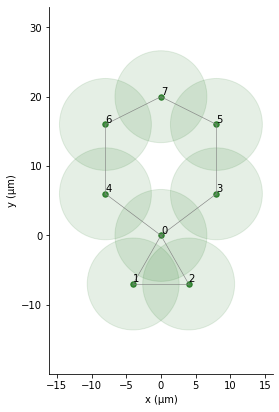

{'00111001', '01011001'}


In [2]:
# pos = np.array([[0., 0.], [-4, -7], [4,-7], [8,6], [-8,6]])
pos = np.array([[0., 0.], [-4, -7], [4,-7], [8,6], [-8,6], [8,16], [-8,16], [0,20]])
# pos = np.array([[0., 0.], [-4, -7], [4,-7], [8,6], [-8,6], [8,16], [-8,16], [0,20], [16,18], [-18,12]])

G = pos_to_graph(pos)
qubits = dict(enumerate(pos))

reg = Register(qubits)
reg.draw(blockade_radius=Chadoq2.rydberg_blockade_radius(1.), draw_graph=True, draw_half_radius=True )

mis_ref = nx_mis(G)
print(mis_ref)

In [3]:
layers = 1
time_unit = 1000 # = 1 microsecond
detuning_amplitude = 1.
guess = {'t': np.random.uniform(8, 10, layers),
         's': np.random.uniform(1, 3, layers)}

# Parametrized sequence
seq = Sequence(reg, Chadoq2)
seq.declare_channel('ch0','rydberg_global')

t_list = seq.declare_variable('t_list', size=layers)
s_list = seq.declare_variable('s_list', size=layers)

if layers == 1:
    t_list = [t_list]
    s_list = [s_list]

for t, s in zip(t_list, s_list):
    pulse_1 = Pulse.ConstantPulse(time_unit*t, 1., 0., 0)
    pulse_2 = Pulse.ConstantPulse(time_unit*s, 1., detuning_amplitude, 0)

    seq.add(pulse_1, 'ch0', protocol='no-delay')
    seq.add(pulse_2, 'ch0', protocol='no-delay')

# Bounds for max total pulse length (machine max = 100)
max_time = 10.
step_time = max_time/layers
lb = []
ub = []
for t in t_list:
    lb.append(0.016)
    ub.append(step_time*0.7)
for s in s_list:
    lb.append(0.016)
    ub.append(step_time*0.3)
np_ub = np.array(ub)
np_lb = np.array(lb)

#Create direct bounds
dbounds = []
for i in range(len(lb)):
    dbounds.append( (lb[i], ub[i]) )
print(dbounds)

[(0.016, 7.0), (0.016, 3.0)]


In [27]:
def quantum_loop(parameters, draw=False, printx=False):
    if printx==True:
        print(parameters)
    t_params, s_params = 4 * (np.rint( (np.reshape(parameters, (2, layers)) * 1000) /4 ) / 1000 )
    assigned_sequence = seq.build(t_list=t_params, s_list=s_params)
    assigned_sequence.measure('ground-rydberg')
    if draw:
        assigned_sequence.draw()
    
    # Noisy
    # config_all_noise = SimConfig(noise=('SPAM'), runs=100, samples_per_run=10, eta=0)
    # simul = Simulation(assigned_sequence, sampling_rate=0.2, evaluation_times='Minimal', config=config_all_noise)
    
    simul = Simulation(assigned_sequence, sampling_rate=.01)
    results = simul.run(nsteps=1e10)
    return results.sample_final_state()

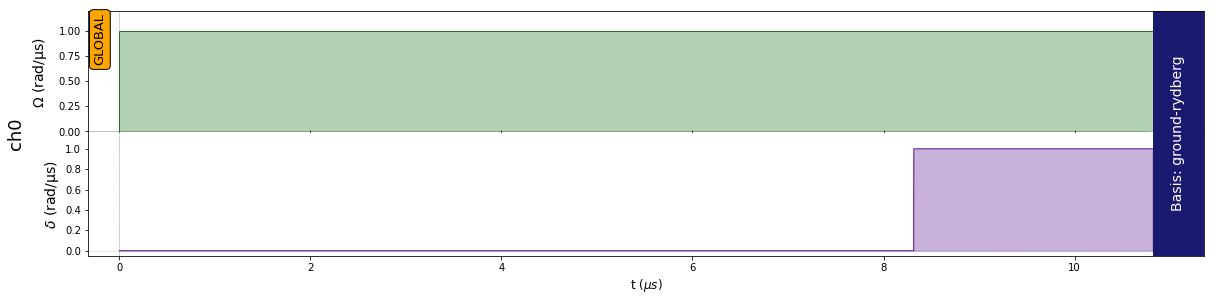

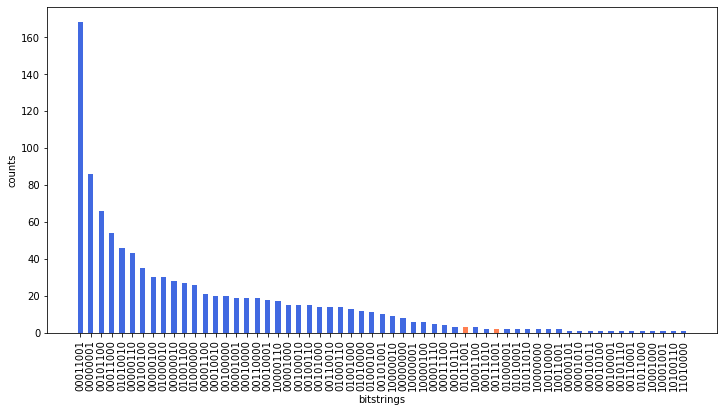

In [28]:
example_dict = quantum_loop(np.r_[guess['t'], guess['s']], draw=True)
plot_distribution(example_dict, mis_ref)


In [29]:
def get_cost_colouring(bitstring, G, penalty=1):
    z = np.array(list(bitstring), dtype=int)
    A = nx.to_numpy_matrix(G)
    # Add penalty and bias:
    cost = penalty*(z.T @ np.triu(A) @ z) - np.sum(z)
    return cost

def get_cost(counter,G):
    cost = sum(counter[key] * get_cost_colouring(key,G) for key in counter)
    return cost / sum(counter.values()) # Divide by total samples

def func(param,*args):
    G = args[0]
    C = quantum_loop(param);
    cost = get_cost(C,G)
    return cost

print(get_cost_colouring(list(mis_ref)[0], G))
print(get_cost(example_dict, G))

-4.0
-2.146


[1.09493476 1.091903  ]


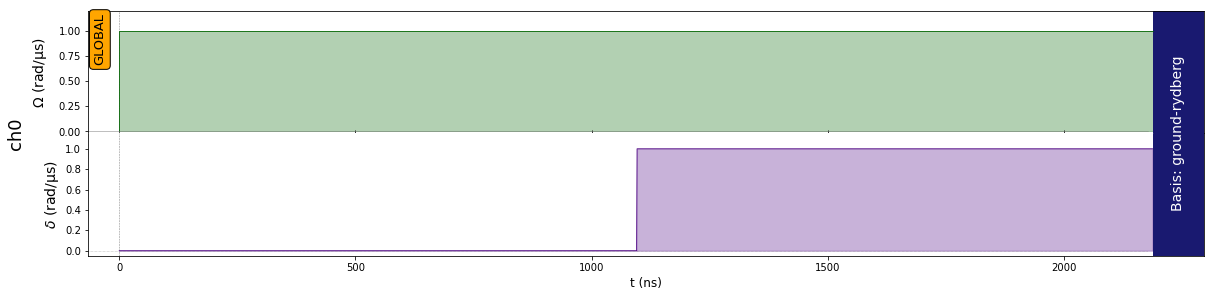

-2.839


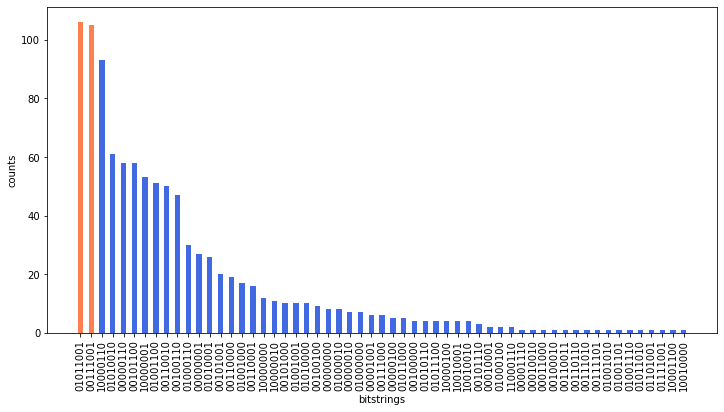

In [30]:
res = minimize(func,
               args=G,
               x0=np.array([1. for i in range(2*layers)]),
               method='Nelder-Mead',
               tol=1e-6,
            #    bounds=Bounds(np_lb,np_ub),
               options = {'maxiter': 50, 'disp': True}
              )

print(res.x)
count_dict = quantum_loop(res.x, draw=True)
print(get_cost(count_dict, G))
plot_distribution(count_dict, mis_ref)

['royalblue', 'coral', 'royalblue', 'coral', 'coral', 'royalblue', 'royalblue', 'coral']


<ipython-input-31-1e45cd1813d3>:6: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  f.show()


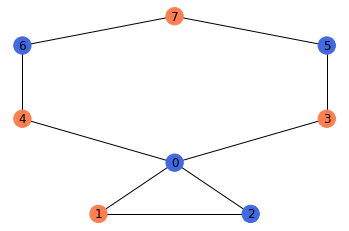

In [31]:
cmap = ['royalblue','coral']
clist = [cmap[int(c)] for c in get_mis_string(count_dict)]
print(clist)
f = plt.figure()
nx.draw(G, pos=pos, node_color=clist, with_labels=True, ax=f.add_subplot(111))
f.show()